# Linear Channel

## Model

- $p(x \mid z) = \delta(x - Wz)$
- infer $z$ (backward) or $x = Wz$ (forward) from $y = x + \mathcal{N}(v_{\rm noise})$
- prior $\mathcal{N}(z \mid r_0, v_0)$ or $a_z=\frac{1}{v_0}, b_z=\frac{r_0}{v_0}$
- likelihood $\mathcal{N}(y \mid x, v_{\rm noise})$ or $a_x=\frac{1}{v_{\rm noise}}, b_x=\frac{y}{v_{\rm noise}}$
- $Z =  \int dxdz\, e^{-\frac{1}{2} a_x x^2 + b_x x} \, p(x\mid z) \, e^{-\frac{1}{2} a_z z^2 + b_z z} =  \int dz\, e^{-\frac{1}{2} a_x (Wz)^2 + b_x Wz} \, e^{-\frac{1}{2} a_z z^2 + b_z z}$

In [1]:
%matplotlib inline
import numpy as np, pandas as pd
from tramp.experiments import qplot

## Posterior

In [2]:
#%run channel_linear.py

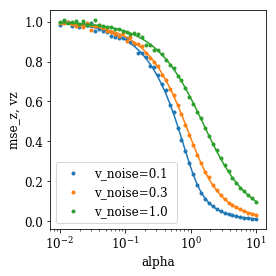

In [3]:
df = pd.read_csv("channel_linear_posterior.csv")
df_avg = df.groupby(["alpha","v_noise"]).mean().reset_index()
qplot(
    df_avg, 
    x="alpha", y=["mse_z","vz"], y_markers=[".","-"], color="v_noise",
    xlog=True
)

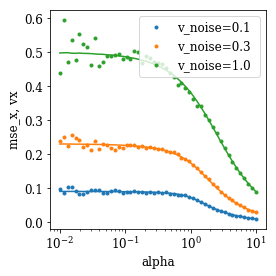

In [4]:
qplot(
    df_avg, 
    x="alpha", y=["mse_x","vx"], y_markers=[".","-"], color="v_noise",
    xlog=True
)

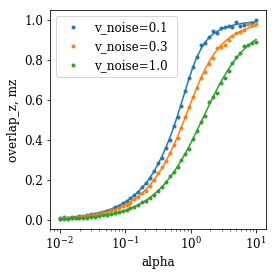

In [5]:
qplot(
    df_avg, 
    x="alpha", y=["overlap_z","mz"], y_markers=[".","-"], color="v_noise",
    xlog=True
)

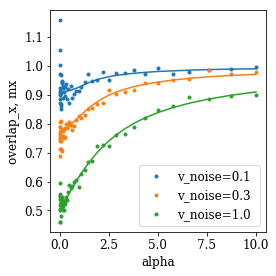

In [6]:
qplot(
    df_avg, 
    x="alpha", y=["overlap_x","mx"], y_markers=[".","-"], color="v_noise"
)

## Error function


<div class="alert alert-success">
For the LinearChannel with $\alpha = \frac{N_x}{N_z}$ we have $a_z v_z = 1 - n_{\rm eff}$
and $\alpha \, a_x v_x = n_{\rm eff}$
</div>

In [7]:
wrt_alpha = pd.read_csv("channel_linear_error_wrt_alpha.csv")
wrt_ax = pd.read_csv("channel_linear_error_wrt_ax.csv")
for df in [wrt_alpha, wrt_ax]:
    df["1-n_eff"] = 1 - df["n_eff"]
    df["n_eff/alpha"] = df["n_eff"]/df["alpha"]

### Checking that $a_z v_z = 1 - n_{\rm eff}$ and $a_x v_x = \frac{1}{\alpha} n_{\rm eff}$

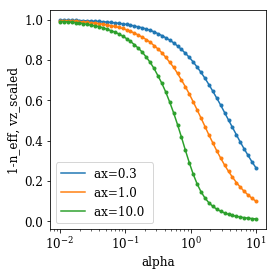

In [8]:
# checking that az vz = 1 - n_eff
qplot(
    wrt_alpha, 
    x="alpha", y=["1-n_eff","vz_scaled"],y_markers=["-","."], color="ax",
    xlog=True
)

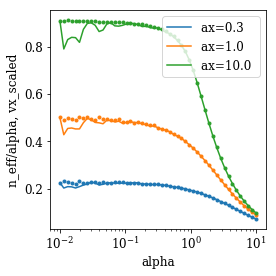

In [9]:
# checking that ax vx = n_eff / alpha
qplot(
    wrt_alpha, 
    x="alpha", y=["n_eff/alpha","vx_scaled"],y_markers=["-","."], color="ax",
    xlog=True
)

### Evolution wrt $\alpha$ and $a_x$

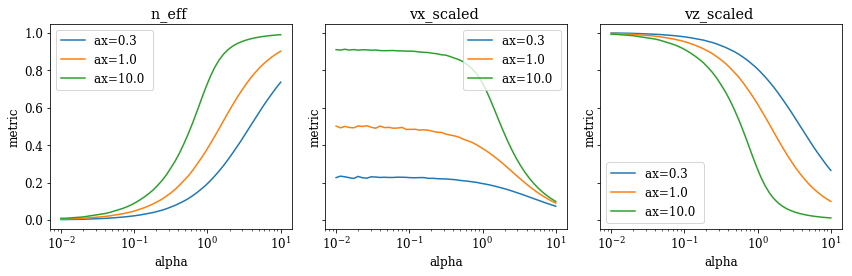

In [10]:
from tramp.utils.misc import gather
metrics = gather(wrt_alpha, ["vz_scaled", "vx_scaled", "n_eff"], "metric", "metric_name")
qplot(
    metrics, 
    x="alpha", y="metric", column="metric_name", color="ax", 
    xlog=True, rename={"metric_name=":""}
)

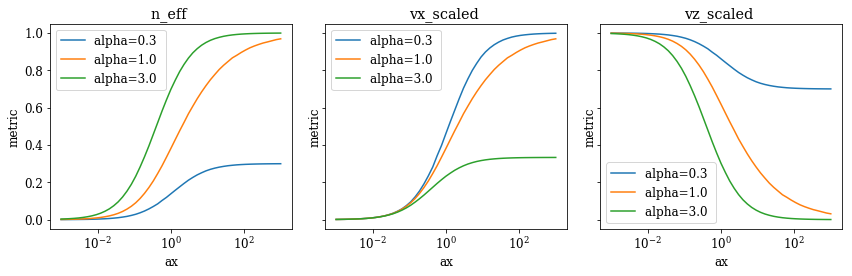

In [11]:
metrics = gather(wrt_ax, ["vz_scaled", "vx_scaled", "n_eff"], "metric", "metric_name")
qplot(
    metrics, 
    x="ax", y="metric", column="metric_name", color="alpha", 
    xlog=True, rename={"metric_name=":""}
)

## Numerical stability


In [12]:
from tramp.channels import LinearChannel
from tramp.ensembles import GaussianEnsemble
M, N = 700, 1000
alpha = M/N
W = GaussianEnsemble(M,N).generate()
channel = LinearChannel(W)
print(f"alpha={channel.alpha} rank={channel.rank} Nz={channel.Nz} Nx={channel.Nx}")
iN = np.ones(N)
iM = np.ones(M)

alpha=0.7 rank=700 Nz=1000 Nx=700


### Limit $az \rightarrow \infty$ 

We should have $n_{\rm eff}=v_z=v_x=0$

In [13]:
az, ax, tau = 1e15, 1, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.1e} vz={vz:.1e} vx={vx:.1e}")

az=1.0e+15 ax=1.0e+00 n_eff=7.0e-16 vz=1.0e-15 vx=1.0e-15


In [14]:
az, ax, tau = np.inf, 1, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.1e} vz={vz:.1e} vx={vx:.1e}")

az=inf ax=1.0e+00 n_eff=0.0e+00 vz=0.0e+00 vx=0.0e+00


### Limit $ax \rightarrow \infty$ 

We should have $n_{\rm eff}=\frac{R}{N_z}, v_z=\frac{1}{a_z}(1-\frac{R}{N_z}), v_x=0$

In [15]:
az, ax, tau = 1, 1e15, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
scaled_rank = channel.rank / channel.Nz
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.2f} scaled_rank={scaled_rank:.2f} vz={vz:.1e} vx={vx:.1e}")

az=1.0e+00 ax=1.0e+15 n_eff=0.70 scaled_rank=0.70 vz=3.0e-01 vx=1.0e-15


In [16]:
az, ax, tau = 1, np.inf, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
scaled_rank = channel.rank / channel.Nz
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.2f} scaled_rank={scaled_rank:.2f} vz={vz:.1e} vx={vx:.1e}")

az=1.0e+00 ax=inf n_eff=0.70 scaled_rank=0.70 vz=3.0e-01 vx=0.0e+00


### Limit $az \rightarrow 0$

We should have $n_{\rm eff}=\frac{R}{N_z}, v_x=\frac{1}{a_x}\frac{R}{N_x}$, $v_z = \infty$ when $R<N_z$ or $v_z=\frac{1}{ax}<\frac{1}{\lambda}>$ when $R=N_z$

In [17]:
az, ax, tau = 1e-15, 1, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.1e} vz={vz:.1e} vx={vx:.1e}")

az=1.0e-15 ax=1.0e+00 n_eff=7.0e-01 vz=3.0e+10 vx=1.0e+00


In [18]:
az, ax, tau = 0, 1, 1
n_eff =  channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az} ax={ax} n_eff={n_eff} vz={vz} vx={vx}")

az=0 ax=1 n_eff=0.7 vz=30000000002.357876 vx=1.0


### Limit $ax \rightarrow 0$

We should have $n_{\rm eff}=0, v_z=\frac{1}{a_z}$ and $v_x=\frac{1}{a_z}\frac{R}{N_x}<\lambda>$

In [19]:
az, ax, tau = 1, 1e-15, 1
n_eff = channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.1e} vz={vz:.1e} vx={vx:.1e}")

az=1.0e+00 ax=1.0e-15 n_eff=7.0e-16 vz=1.0e+00 vx=1.0e+00


In [20]:
az, ax, tau = 1, 0, 1
n_eff = channel.compute_n_eff(az, ax)
vz = channel.compute_backward_error(az, ax, tau)
vx = channel.compute_forward_error(az, ax, tau)
print(f"az={az:.1e} ax={ax:.1e} n_eff={n_eff:.1e} vz={vz:.1e} vx={vx:.1e}")

az=1.0e+00 ax=0.0e+00 n_eff=0.0e+00 vz=1.0e+00 vx=1.0e+00
